In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(42)
np.random.seed(42)

In [2]:
dataset = pd.read_csv('lorenz.csv', header=0)
# eliminate all white spaces from the column names
dataset.columns = dataset.columns.str.replace(' ', '')

dataset.head()

,t,x,y,z,particle
0,0.000000,11.685804,2.770249,11.924933,0
1,0.010013,10.794248,4.641039,11.931012,0
2,0.020025,10.178927,6.355903,12.126127,0
3,0.030038,9.796625,7.936780,12.473641,0
4,0.040050,9.610640,9.405884,12.954580,0


### We can decompose the trajectories to better understand the time series

##### But notice that it would not be good to train the network in the separated time series, as they have non-linear dependency on the other coordinates

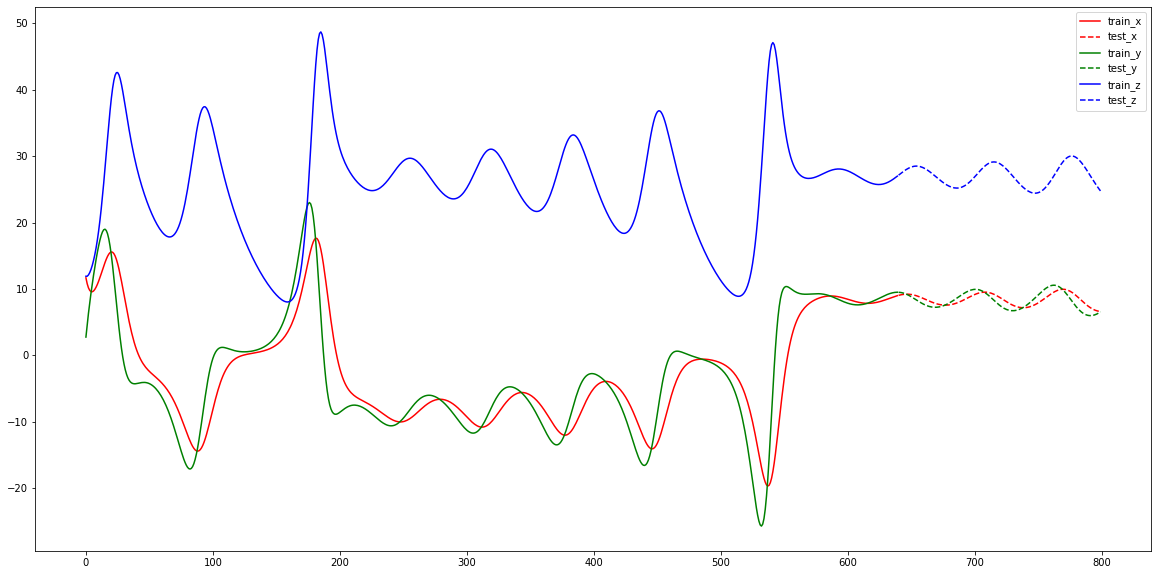

In [7]:
dataset0 = dataset[dataset['particle'] == 0]
# drop column particles for the moment
dataset0 = dataset0.drop(['particle'], axis=1)

## train test split just to plot the data
train_size = int(len(dataset0) * 0.8)
test_size = len(dataset0) - train_size
train, test = dataset0.iloc[0:train_size,:], dataset0.iloc[train_size:len(dataset),:]

## plot to undertsand the data split
plt.figure(figsize=(20, 10))

plt.plot(train['x'], label='train_x', color='red')
plt.plot(test['x'], label='test_x', linestyle='--', color='red')
plt.plot(train['y'], label='train_y', color='green')
plt.plot(test['y'], label='test_y', linestyle='--', color='green')
plt.plot(train['z'], label='train_z', color='blue')
plt.plot(test['z'], label='test_z', linestyle='--', color='blue')

plt.legend()
plt.show()

### Let us first train on one particle only, to try to see things

In [8]:

# separate into X dataset and Y dataset, for now as dataframes
X = dataset0['t']
Y = dataset0.drop(['t'], axis=1)

# scale the columns of the X and Y datasets
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.values.reshape(-1, 1))
Y = scaler.fit_transform(Y)

Y

array([[0.8400911 , 0.58414555, 0.09520425],
       [0.81618491, 0.62256438, 0.09535382],
       [0.79968567, 0.65778112, 0.10015469],
       ...,
       [0.70590733, 0.65722414, 0.42400516],
       [0.70496137, 0.65958566, 0.41749174],
       [0.70441835, 0.66226118, 0.4112985 ]])

In [9]:
# FORMAT_DATA
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2 because 
                the input is the current value and the previous value.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        #print("b ", b)
        # Reshape so that each data point is contained in its own array
        #a = np.reshape (a, (len(a), 1))
        #print("a ", a)

        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output



In [10]:
## train test split 
train_size = int(len(dataset0) * 0.8)
test_size = len(dataset0) - train_size
ytrain, ytest = Y[0:train_size,:], Y[train_size:len(Y),:]

In [11]:
## format data for RNN
rnn_input, rnn_train = format_data(ytrain, 2)

In [12]:
# ## Defining the Recurrent Neural Network Using Keras
# 
# The following method defines a simple recurrent neural network in keras consisting of one input layer, one hidden layer, and one output layer.

def rnn(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 3
    # Number of neurons in the hidden layer
    hidden_neurons = 200
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
                    


    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense", activation='leaky_relu')(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [13]:
model = rnn(length_of_sequences = rnn_input.shape[1])

In [15]:
hist = model.fit(rnn_input, rnn_train, epochs=1000, batch_size=None, verbose=0, shuffle=False)

2023-04-06 11:55:56.583292: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
def test_rnn (x1, y):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    train = int(0.8 * len(y))
    y_pred = y[:train].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[y[train-2], y[train-1]]])
    print(next_input)
    # Save the very last point in the training data set.  This will be used later.
    last = [y[train-1]]

    # Iterate until the complete data set is created.
    for i in range (train, len(y)):
        # Predict the next point in the data set using the previous two points.

        next = model.predict(next_input, verbose=0)

        # convert to list 
        next = next.tolist()
        # Append just the number of the predicted data set
        y_pred.append(next[0])
        #print("y_pred[0]", y_pred[0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = [last, next]
        next_input = np.array(next_input, dtype=object)
        next_input = np.reshape(next_input, (1, 2, 3))
        next_input = np.asarray(next_input).astype('float32')
        last = next


    # Print the mean squared error between the known data set and the predicted data set.
    mse = np.square(np.subtract(y[train:], y_pred[train:])).mean()
    print('pct MSE: ', mse/np.mean(y))
    # Save the predicted data set as a csv file for later use
    name = 'Predicted'+str(train)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.

    # break y_pred into actual x, y, z coordinates
    x_plot = y[:,0]
    y_plot = y[:,1]
    z_plot = y[:,2]

    # break y_pred into actual x, y, z coordinates
    x_pred_plot = [i[0] for i in y_pred[train:]]
    y_pred_plot = [i[1] for i in y_pred[train:]]
    z_pred_plot = [i[2] for i in y_pred[train:]]


    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(projection='3d')

    # lineplot instead of scatterplot
    ax.plot(x_plot, y_plot, z_plot, c='b', label='Actual')
    ax.plot(x_pred_plot, y_pred_plot, z_pred_plot, c='r', label='Predicted', linestyle='dashed')
    ax.plot(x_plot[train:], y_plot[train:], z_plot[train:], c='g', label='Testing Data')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('Actual vs. Predicted')
    plt.show()
    return y_pred, y


[[[0.7665608  0.72262919 0.4622312 ]
  [0.76808942 0.72279576 0.46583358]]]
pct MSE:  0.02682679858497399


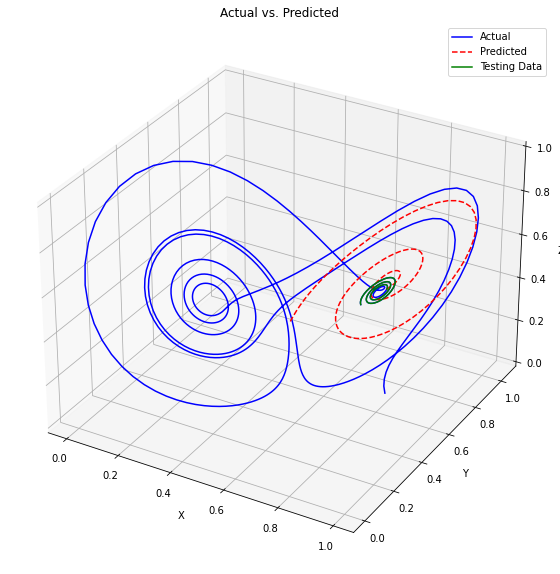

In [20]:
y_pred, y = test_rnn(X, Y)

### It is clear that this is not good. Let us try to train on more data.

In [2]:
dataset = pd.read_csv('lorenz.csv', header=0)

# eliminate all white spaces from the column names
dataset.columns = dataset.columns.str.replace(' ', '')

# remove column t 
dataset = dataset.drop(['t'], axis=1)

(7900, 2, 10, 3)
Epoch 1/10
3160/3160 [==============================] - 11s 3ms/step - loss: 0.8498 - val_loss: 1.1117
Epoch 2/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8447 - val_loss: 1.1559
Epoch 3/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8505 - val_loss: 1.0435
Epoch 4/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8391 - val_loss: 0.9855
Epoch 5/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8342 - val_loss: 0.9173
Epoch 6/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8256 - val_loss: 1.2262
Epoch 7/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8129 - val_loss: 0.9443
Epoch 8/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8303 - val_loss: 0.9895
Epoch 9/10
3160/3160 [==============================] - 9s 3ms/step - loss: 0.8114 - val_loss: 1.0129
Epoch 10/10
3160/3160 [==============================] - 9s 3ms/

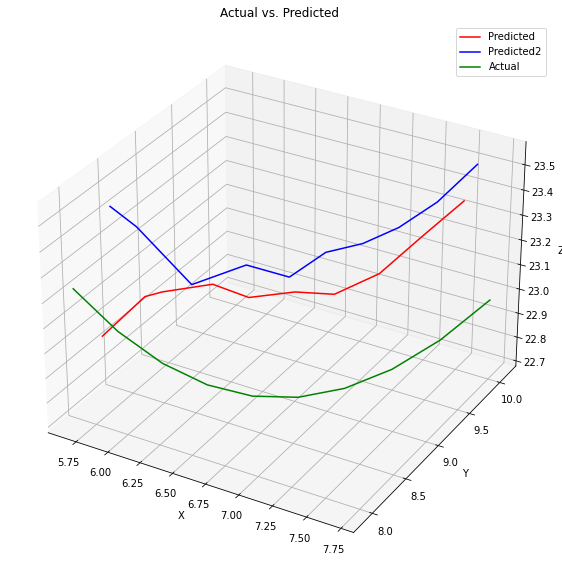

In [85]:
# define the sliding window size
window_size = 10

# create a list of input-output pairs for each particle
pairs_list = []
for particle_id in range(10):
    trajectory = dataset[dataset['particle'] == particle_id][['x', 'y', 'z']].values
    for i in range(len(trajectory) - window_size):
        input_sequence = trajectory[i:i+window_size] # the first 10 points

        output_sequence = trajectory[i+1:i+window_size+1] # the next 10 points shifted by 1
        pairs_list.append((input_sequence, output_sequence))

# shuffle the list of pairs
np.random.shuffle(pairs_list)

print(np.shape(pairs_list)) # this can be passed to a RNN LSTM

# split the data into training and testing sets
train_size = int(0.8 * len(pairs_list))
train_pairs = pairs_list[:train_size]
test_pairs = pairs_list[train_size:]

# create the training and testing data
train_input = np.array([pair[0] for pair in train_pairs])
train_output = np.array([pair[1] for pair in train_pairs])
test_input = np.array([pair[0] for pair in test_pairs])
test_output = np.array([pair[1] for pair in test_pairs])



# define the model
model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_size, 3), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3)) # time distributed means that the same dense layer is applied to each time step
])


model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_size, 3), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3)) # time distributed means that the same dense layer is applied to each time step
])

# instead of time distributed, we can also use a regular dense layer
model3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_size, 3), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(3) 
])



# define a physics informed custom loss to be used by the keras model
def custom_loss(y_true, y_pred):
    # calculate the loss
    mse_loss = tf.reduce_mean(tf.square(y_pred - y_true)) # reduce mean is the average of the loss
    # calculate the physics loss
    physics_loss = tf.reduce_mean(tf.square(y_pred[:, 1:, :] - y_pred[:, :-1, :]))
    # return the weighted sum of the two losses
    return mse_loss + physics_loss


# compare the impact of the custom loss function and the default mse loss function
model.compile(optimizer='adam', loss=custom_loss)

model2.compile(optimizer='adam', loss=custom_loss)


# train the model
model.fit(train_input, train_output, epochs=10, batch_size=32, validation_data=(test_input, test_output)) 
model2.fit(train_input, train_output, epochs=10, batch_size=2, validation_data=(test_input, test_output))
# batch size is the number of samples per gradient update. If batch size is big then the model will train faster but it will be less accurate

# evaluate the model
model.evaluate(test_input, test_output)
model2.evaluate(test_input, test_output)

# make predictions
predictions = model.predict(test_input)
predictions2 = model2.predict(test_input)

# plot the predictions
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(projection='3d')

# plot the first particle
ax.plot(predictions[0,:,0], predictions[0,:,1], predictions[0,:,2], c='r', label='Predicted')
ax.plot(predictions2[0,:,0], predictions2[0,:,1], predictions2[0,:,2], c='b', label='Predicted2')
ax.plot(test_output[0,:,0], test_output[0,:,1], test_output[0,:,2], c='g', label='Actual')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
plt.title('Actual vs. Predicted')
plt.show()





1/1 [==============================] - 0s 32ms/step


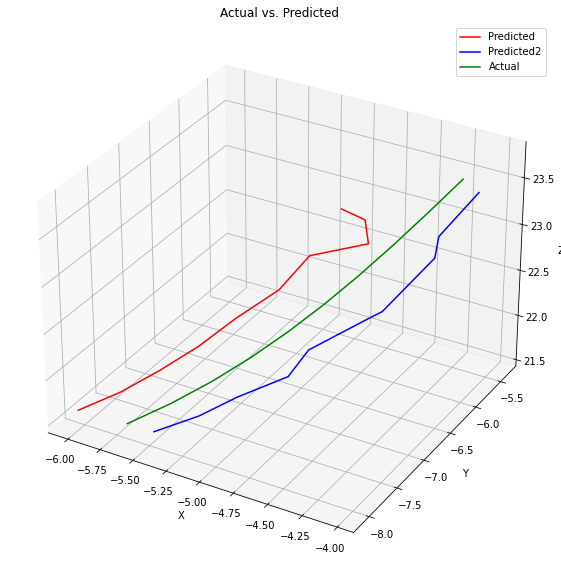

In [82]:
# now we use the trained model to predict the next 10 points of the Lorenz system
# we will use the last 10 points of the Lorenz system as the input
# we will then compare the predicted points to the actual points

# define the input sequence
input_sequence = dataset[dataset['particle'] == 5][['x', 'y', 'z']].values[-window_size:]

# make predictions
predictions1 = model.predict(np.array([input_sequence]))[0]
predictions2 = model2.predict(np.array([input_sequence]))[0]    

# plot the predictions
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(projection='3d')

# plot the first particle
ax.plot(predictions1[:,0], predictions1[:,1], predictions1[:,2], c='r', label='Predicted')
ax.plot(predictions2[:,0], predictions2[:,1], predictions2[:,2], c='b', label='Predicted2')
ax.plot(input_sequence[:,0], input_sequence[:,1], input_sequence[:,2], c='g', label='Actual')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
plt.title('Actual vs. Predicted')
plt.show()



In [57]:
prediction[0]

array([[  7.0066686,  15.644724 ,  37.824875 ],
       [ 11.358298 ,  15.90885  ,  48.29017  ],
       [ -4.4411497,  -7.561361 ,  27.016851 ],
       [ 18.209776 ,  14.351394 ,  70.73451  ],
       [ -3.6473153, -21.775217 ,  68.38145  ],
       [  3.6047897,   7.2384977,  22.650877 ],
       [ -9.800139 , -19.94602  ,  75.45246  ],
       [  1.3979361,   6.1963534,  22.043734 ],
       [-12.018653 , -20.825777 ,  75.00733  ],
       [  0.2794258,   5.5476184,  21.539602 ]], dtype=float32)